In [1]:
import numpy as np
from matplotlib import pyplot as plt

from conservative_nn.nn_lagrangian import SchwarzschildNNLagrangian
from conservative_nn.nn_lagrangian_model import NNLagrangianModel
from conservative_nn.dynamical_system import SchwarzschildSystem
from conservative_nn.monitors import (
    PositionMonitor,
    SingleParticleInvariantMonitor,
    SchwarzschildInvariantMonitor,
    InvariantMonitor
)
    
from conservative_nn.trajectory_generator import TrajectoryGenerator
from conservative_nn.initializer import SchwarzschildConstantInitializer


%matplotlib inline
%load_ext autoreload
%autoreload 2


## Load models from disk and run trajectory generators

In [2]:
dt = 0.01
# final time
t_final = 1000.0
dim = 4

r_s = 0.1
initializer = SchwarzschildConstantInitializer(r_s=r_s)
perturbed_initializer = SchwarzschildConstantInitializer(r_s=r_s,perturbation=1.E-3)

dynamical_system = SchwarzschildSystem(r_s)

monitors = {}
monitors_nn = {}
monitors_nn_perturbed = {}

for model_label in ["","rot"]:
    # load Lagrangian from disk
    filetag = "" if model_label == "" else "_"+model_label
    model_filename = f"../assets/trained_models/schwarzschild/nn_lagrangian{filetag}/"
    nn_lagrangian = SchwarzschildNNLagrangian.from_saved_model(model_filename)
    model = NNLagrangianModel(nn_lagrangian)
    # Monitors
    monitors[model_label] = [PositionMonitor()]
    monitors_nn[model_label] = [PositionMonitor(),
                                InvariantMonitor(nn_lagrangian),
                                SchwarzschildInvariantMonitor(dynamical_system)]
    monitors_nn_perturbed[model_label] = [PositionMonitor()]

    # Run trajectory generators
    trajectory_generator = TrajectoryGenerator(dynamical_system,
                                               initializer,
                                               monitors[model_label],
                                               f"../assets/trajectories/schwarzschild/exact{filetag:s}",
                                               dt=dt,t_final=t_final)
    trajectory_generator_nn = TrajectoryGenerator(model,
                                                  initializer,
                                                  monitors_nn[model_label],
                                                  f"../assets/trajectories/schwarzschild/nn{filetag:s}",
                                                  dt=dt,t_final=t_final)
    trajectory_generator_nn_perturbed = TrajectoryGenerator(model,
                                                            perturbed_initializer,
                                                            monitors_nn_perturbed[model_label],
                                                            f"../assets/trajectories/schwarzschild/nn_perturbed{filetag:s}",
                                                            dt=dt,t_final=t_final)
    trajectory_generator.run()
    trajectory_generator_nn.run()
    trajectory_generator_nn_perturbed.run()
    T = trajectory_generator.t

## Plot (projection of) trajectories

(4, 100001)
(4, 100001)


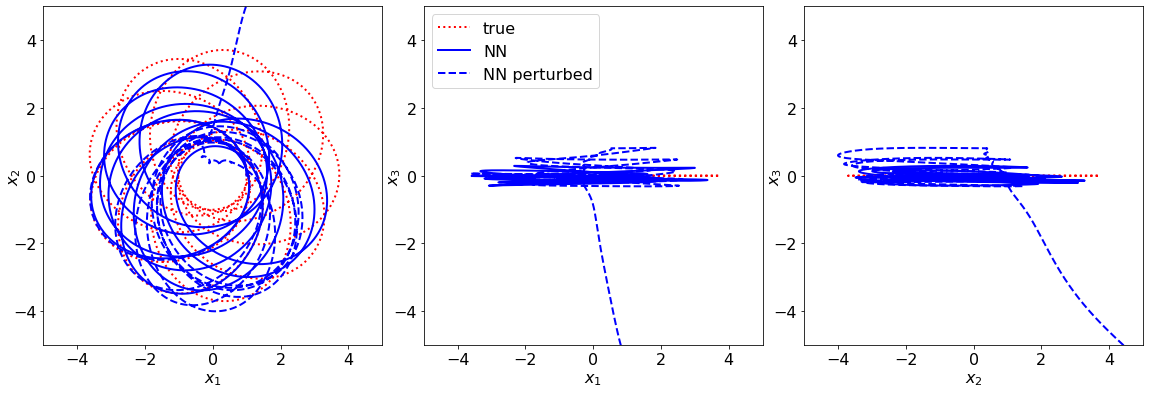

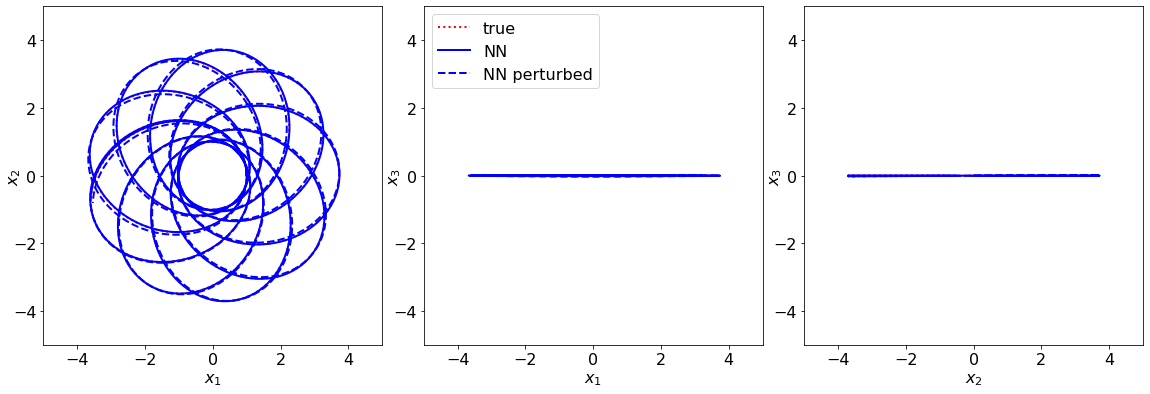

In [13]:
title = {"":"unconstrained","rot":"rotationally invariant"}
fs = 16
for model_label in ["","rot",]:
    # Indices of space dimensions for projection
    fig, axs = plt.subplots(1,3,figsize=(16,8))
    fig.tight_layout()
    q_all = monitors[model_label][0].data
    q_all_nn = monitors_nn[model_label][0].data
    q_all_nn_perturbed = monitors_nn_perturbed[model_label][0].data
    print (q_all.shape)
    idx = [[1,2],[1,3],[2,3]]
    labels = [r"$\tau$","$x_1$","$x_2$","$x_3$"]
    Phi = np.arange(-np.pi,+np.pi,1.E-3)
    for j in range(3):
        axs[j].set_aspect(1)
        axs[j].set_xlim(-5,+5)
        axs[j].set_ylim(-5,+5)

        axs[j].plot(q_all[idx[j][0],:],q_all[idx[j][1],:],
                    linewidth=2,linestyle=":",color="red",
                    label="true")
        axs[j].plot(q_all_nn[idx[j][0],:],q_all_nn[idx[j][1],:],
                    linewidth=2,color="blue",
                    label="NN")
        axs[j].plot(q_all_nn_perturbed[idx[j][0],:],
                    q_all_nn_perturbed[idx[j][1],:],linewidth=2,color="blue",linestyle="--",
                    label="NN perturbed")
        if j==1:
            axs[j].legend(loc="upper left",fontsize=fs)
        axs[j].set_xlabel(labels[idx[j][0]],fontsize=fs)
        axs[j].set_ylabel(labels[idx[j][1]],labelpad=-10,fontsize=fs)
        axs[j].tick_params(axis='both', which='major', labelsize=fs)
    #fig.suptitle(title[model_label],fontsize=24)
    separator = "_" if model_label == "rot" else "" 
    fig.savefig(f"trajectories_schwarzschild{separator}{model_label}.pdf",bbox_inches="tight")


## Plot invariants

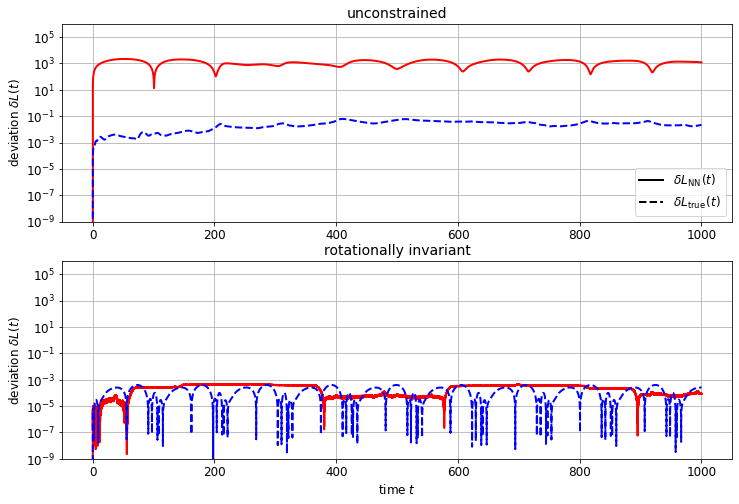

In [16]:
model_label_list = ["","rot",]
fs=12

title = {"":"unconstrained",
         "rot":"rotationally invariant"}

fig, axs = plt.subplots(2, 1, figsize=(12,8))
for row in [0,1]:
    model_label = model_label_list[row]
    invariant = monitors_nn[model_label][1].data
    invariant_true = monitors_nn[model_label][2].data
    ax = axs[row]
    # Plot angular momentum
    
    Q = np.linalg.norm(invariant[:,:].T-invariant[:,0],axis=1) # / np.linalg.norm(invariant[:,0])
    Q_true = np.linalg.norm(invariant_true[:,:].T-invariant_true[:,0],axis=1) # / np.linalg.norm(invariant_true[:,0])
    ax.plot(trajectory_generator_nn.t,Q,linewidth=2,color="red")
    ax.plot(trajectory_generator_nn.t,Q_true,linewidth=2,linestyle="--",color="blue")
    if row==0:
        ax.plot([],[],linewidth=2,color="black",label=r"$\delta L_{\operatorname{NN}}(t)$")
        ax.plot([],[],linewidth=2,color="black",linestyle="--",label=r"$\delta L_{\operatorname{true}}(t)$")
        ax.legend(loc="lower right",fontsize=fs)
    else:
        ax.set_xlabel("time $t$",fontsize=fs)
    ax.set_ylabel(r"deviation $\delta L(t)$",fontsize=fs)
    ax.set_yscale("log")
    ax.set_ylim(1.E-9,1.E6)
    ax.set_title(title[model_label],fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.grid()

plt.savefig("invariants_schwarzschild.pdf",bbox_inches="tight")
plt.show()


## Plot deviation between NN and true trajectories

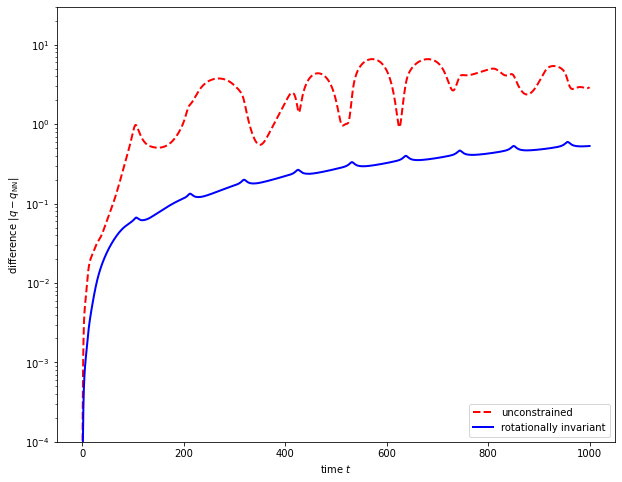

In [5]:
model_label_list = ["","rot"]

label = {"":"unconstrained",
         "rot":"rotationally invariant"}
color = {"":"red","rot":"blue"}
linestyle = {"":"--","rot":"-"}

plt.figure(figsize=(10,8))
plt.gca()
ax = plt.gca()
ax.set_yscale("log")
ax.set_ylim(1.E-4,30)
for model_label in model_label_list:
    q_all = monitors[model_label][0].data
    q_all_nn = monitors_nn[model_label][0].data
    dq = np.linalg.norm(q_all_nn[:,:]-q_all[:,:],axis=0)
    plt.plot(trajectory_generator_nn.t,dq,linewidth=2,
             label=label[model_label],
             color=color[model_label],
             linestyle=linestyle[model_label])
ax.set_xlabel("time $t$")
ax.set_ylabel(r"difference $|q-q_{\operatorname{NN}}|$")
plt.legend(loc="lower right")
plt.show()

## Plot deviation between unperturbed and perturbed trajectories

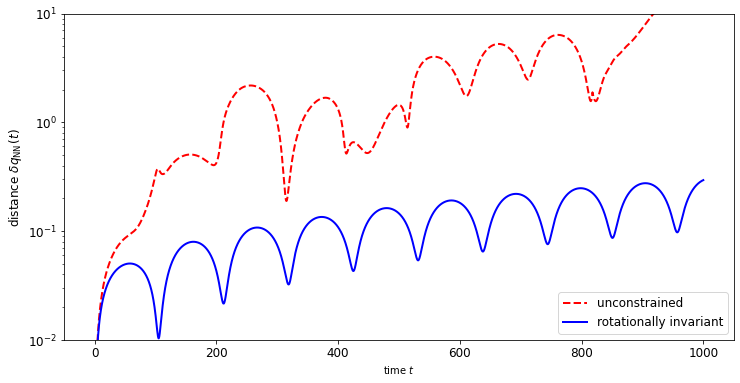

In [19]:
model_label_list = ["","rot"]
fs = 12

label = {"":"unconstrained",
         "rot":"rotationally invariant"}

label = {"":"unconstrained",
         "rot":"rotationally invariant"}
color = {"":"red","rot":"blue"}
linestyle = {"":"--","rot":"-"}


plt.figure(figsize=(12,6))
plt.gca()
ax = plt.gca()
ax.set_yscale("log")
ax.set_ylim(1.E-2,10)
for model_label in model_label_list:
    q_all_nn = monitors_nn[model_label][0].data
    q_all_nn_perturbed = monitors_nn_perturbed[model_label][0].data
    dq = np.linalg.norm(q_all_nn[:,:]-q_all_nn_perturbed[:,:],axis=0)
    plt.plot(trajectory_generator_nn.t,dq,linewidth=2,
             label=label[model_label],
             color=color[model_label],
             linestyle=linestyle[model_label])
ax.set_xlabel("time $t$")
ax.set_ylabel(r"distance $\delta q_{\operatorname{NN}}(t)$",fontsize=fs)
plt.legend(loc="lower right",fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
plt.savefig("perturbation_schwarzschild.pdf",bbox_inches="tight")
plt.show()